In [1]:
import sys
sys.path.append('../')

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib.pyplot import imshow
from tqdm import tqdm
import torch
from torch.nn import Module
from torchsummary import summary

from collections import namedtuple, defaultdict
from pathlib import Path
import time

%matplotlib inline
rcParams['figure.figsize'] = (10, 15)

In [3]:
from src.constructor.config_structure import TrainConfigParams
from src.registry import TASKS
from src.constructor.data import create_dataset
from src.constructor.trainer import download_s3_artifact
from train import load_config

In [4]:
def load_hparams(config_path):
    hparams = load_config(config_path)
    hparams = TrainConfigParams(**hparams)
    
    return hparams

In [5]:
config_path = '../examples/configs/detection.yml'
config = load_hparams(config_path)

In [6]:
# Prevent XBM from loading
config.task.params['xbm_params'] = None

In [7]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [8]:
# checkpoint = torch.load(download_s3_artifact('s3://ml-fips/mlruns/eedfa4c178bd44f8bc6c44cdcc0f4814/artifacts/last.ckpt', '/tmp'), map_location=device)
model = TASKS.get(config.task.name)(config)
# model = model.to(device)
# model.load_state_dict(checkpoint['state_dict'])
# model.eval();
model = model.to(device).half()

In [9]:
data_params = config.data
dataset_name = data_params.train_params.name
common_params = data_params.common_params
other_params = data_params.train_params
# other_params = data_params.valid_params
# other_params = data_params.test_params

dataset = create_dataset(dataset_name, common_params, other_params)
dataset[100]

{'input': tensor([[[-8.7256e-01, -9.1406e-01, -9.9805e-01,  ..., -9.9219e-01,
           -9.9219e-01, -9.9219e-01],
          [-9.0430e-01, -9.2676e-01, -9.6680e-01,  ..., -9.9219e-01,
           -9.9219e-01, -9.9219e-01],
          [-9.1406e-01, -9.5752e-01, -9.2627e-01,  ..., -9.9219e-01,
           -9.9219e-01, -9.9219e-01],
          ...,
          [-1.4246e-01,  8.1360e-02,  1.9336e-01,  ..., -5.4736e-01,
           -4.9658e-01, -5.5957e-01],
          [-1.9531e-01, -7.3547e-02, -9.8038e-04,  ..., -4.8950e-01,
           -6.7676e-01, -6.9922e-01],
          [-2.7026e-01, -2.3083e-01, -6.0547e-02,  ..., -3.2251e-01,
           -3.0542e-01, -7.2314e-01]],
 
         [[ 2.9712e-01,  3.4180e-01,  4.2920e-01,  ...,  1.6858e-01,
            1.6858e-01,  1.6858e-01],
          [ 2.9419e-01,  3.5962e-01,  4.5557e-01,  ...,  1.6858e-01,
            1.6858e-01,  1.6858e-01],
          [ 3.9771e-01,  4.2017e-01,  4.5020e-01,  ...,  1.6858e-01,
            1.6858e-01,  1.6858e-01],
          

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


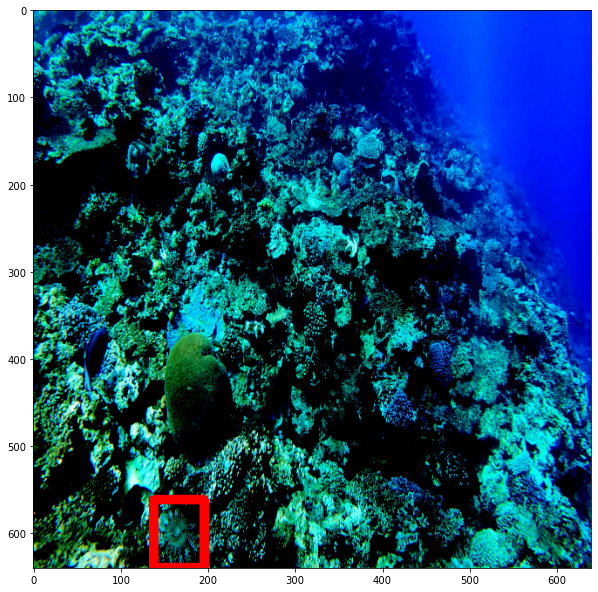

In [10]:
import cv2
import matplotlib.pyplot as plt

img = dataset[100]['input'].numpy()
img = np.int32(img * 255)
img = np.moveaxis(img, 0, 2)
# img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
bboxes = dataset[100]['target_bboxes'].numpy()[0].astype(int)
# Ending coordinate, here (220, 220)
# represents the bottom right corner of rectangle
start_point = (bboxes[0], bboxes[1])
end_point = (bboxes[2], bboxes[3])
  
# Blue color in BGR
color = (255, 0, 0)
  
# Line thickness of 2 px
thickness = 10
  
# Using cv2.rectangle() method
# Draw a rectangle with blue line borders of thickness of 2 px
img = cv2.rectangle(img, start_point, end_point, color, thickness)
plt.imshow(img)

In [17]:
img = torch.unsqueeze(dataset[100]['input'], 0).half().to(device)
bboxes = torch.unsqueeze(dataset[100]['target_bboxes'], 0).half().to(device)
labels = torch.unsqueeze(dataset[100]['target_labels'], 0).to(device)
img.shape, bboxes.shape, labels.shape

(torch.Size([1, 3, 640, 640]), torch.Size([1, 1, 4]), torch.Size([1, 1]))

In [18]:
bboxes

tensor([[[138., 561., 196., 639.]]], device='cuda:0', dtype=torch.float16)

In [19]:
# model = model.double()

In [20]:
cls_score, bbox_pred, objectness = model.forward(img)
cls_score[0].shape, cls_score[1].shape, cls_score[2].shape

(torch.Size([1, 2, 80, 80]),
 torch.Size([1, 2, 40, 40]),
 torch.Size([1, 2, 20, 20]))

In [22]:
model.infer_module.forward_train(cls_score, bbox_pred, objectness, bboxes, labels)

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu!

In [ ]:
t = torch.ones((4, 5))
assigned_gt_inds = t.new_full((10, ),
                                                   0,
                                                   dtype=torch.long)
assigned_gt_inds,    t                                              

(tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 tensor([[1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1.]]))

In [17]:
len(answer)

3

In [16]:
answer[0][0].shape, answer[0][1].shape, answer[0][2].shape

(torch.Size([4, 2, 80, 80]),
 torch.Size([4, 2, 40, 40]),
 torch.Size([4, 2, 20, 20]))

In [14]:
answer[1][0].shape, answer[1][1].shape, answer[1][2].shape

(torch.Size([4, 4, 80, 80]),
 torch.Size([4, 4, 40, 40]),
 torch.Size([4, 4, 20, 20]))

In [15]:
answer[2][0].shape, answer[2][1].shape, answer[2][2].shape

(torch.Size([4, 1, 80, 80]),
 torch.Size([4, 1, 40, 40]),
 torch.Size([4, 1, 20, 20]))

In [ ]:
cv2.imread()

In [16]:
# Copyright (c) OpenMMLab. All rights reserved.
import numpy as np
import torch
from torch.nn.modules.utils import _pair


class PointGenerator:

    def _meshgrid(self, x, y, row_major=True):
        xx = x.repeat(len(y))
        yy = y.view(-1, 1).repeat(1, len(x)).view(-1)
        if row_major:
            return xx, yy
        else:
            return yy, xx

    def grid_points(self, featmap_size, stride=16, device='cuda'):
        feat_h, feat_w = featmap_size
        shift_x = torch.arange(0., feat_w, device=device) * stride
        shift_y = torch.arange(0., feat_h, device=device) * stride
        shift_xx, shift_yy = self._meshgrid(shift_x, shift_y)
        stride = shift_x.new_full((shift_xx.shape[0], ), stride)
        shifts = torch.stack([shift_xx, shift_yy, stride], dim=-1)
        all_points = shifts.to(device)
        return all_points

    def valid_flags(self, featmap_size, valid_size, device='cuda'):
        feat_h, feat_w = featmap_size
        valid_h, valid_w = valid_size
        assert valid_h <= feat_h and valid_w <= feat_w
        valid_x = torch.zeros(feat_w, dtype=torch.bool, device=device)
        valid_y = torch.zeros(feat_h, dtype=torch.bool, device=device)
        valid_x[:valid_w] = 1
        valid_y[:valid_h] = 1
        valid_xx, valid_yy = self._meshgrid(valid_x, valid_y)
        valid = valid_xx & valid_yy
        return valid


class MlvlPointGenerator:
    """Standard points generator for multi-level (Mlvl) feature maps in 2D
    points-based detectors.

    Args:
        strides (list[int] | list[tuple[int, int]]): Strides of anchors
            in multiple feature levels in order (w, h).
        offset (float): The offset of points, the value is normalized with
            corresponding stride. Defaults to 0.5.
    """

    def __init__(self, strides, offset=0.5):
        self.strides = [_pair(stride) for stride in strides]
        self.offset = offset

    @property
    def num_levels(self):
        """int: number of feature levels that the generator will be applied"""
        return len(self.strides)

    @property
    def num_base_priors(self):
        """list[int]: The number of priors (points) at a point
        on the feature grid"""
        return [1 for _ in range(len(self.strides))]

    def _meshgrid(self, x, y, row_major=True):
        yy, xx = torch.meshgrid(y, x)
        if row_major:
            # warning .flatten() would cause error in ONNX exporting
            # have to use reshape here
            return xx.reshape(-1), yy.reshape(-1)

        else:
            return yy.reshape(-1), xx.reshape(-1)

    def grid_priors(self,
                    featmap_sizes,
                    dtype=torch.float32,
                    device='cuda',
                    with_stride=False):
        """Generate grid points of multiple feature levels.

        Args:
            featmap_sizes (list[tuple]): List of feature map sizes in
                multiple feature levels, each size arrange as
                as (h, w).
            dtype (:obj:`dtype`): Dtype of priors. Default: torch.float32.
            device (str): The device where the anchors will be put on.
            with_stride (bool): Whether to concatenate the stride to
                the last dimension of points.

        Return:
            list[torch.Tensor]: Points of  multiple feature levels.
            The sizes of each tensor should be (N, 2) when with stride is
            ``False``, where N = width * height, width and height
            are the sizes of the corresponding feature level,
            and the last dimension 2 represent (coord_x, coord_y),
            otherwise the shape should be (N, 4),
            and the last dimension 4 represent
            (coord_x, coord_y, stride_w, stride_h).
        """

        assert self.num_levels == len(featmap_sizes)
        multi_level_priors = []
        for i in range(self.num_levels):
            priors = self.single_level_grid_priors(
                featmap_sizes[i],
                level_idx=i,
                dtype=dtype,
                device=device,
                with_stride=with_stride)
            multi_level_priors.append(priors)
        return multi_level_priors

    def single_level_grid_priors(self,
                                 featmap_size,
                                 level_idx,
                                 dtype=torch.float32,
                                 device='cuda',
                                 with_stride=False):
        """Generate grid Points of a single level.

        Note:
            This function is usually called by method ``self.grid_priors``.

        Args:
            featmap_size (tuple[int]): Size of the feature maps, arrange as
                (h, w).
            level_idx (int): The index of corresponding feature map level.
            dtype (:obj:`dtype`): Dtype of priors. Default: torch.float32.
            device (str, optional): The device the tensor will be put on.
                Defaults to 'cuda'.
            with_stride (bool): Concatenate the stride to the last dimension
                of points.

        Return:
            Tensor: Points of single feature levels.
            The shape of tensor should be (N, 2) when with stride is
            ``False``, where N = width * height, width and height
            are the sizes of the corresponding feature level,
            and the last dimension 2 represent (coord_x, coord_y),
            otherwise the shape should be (N, 4),
            and the last dimension 4 represent
            (coord_x, coord_y, stride_w, stride_h).
        """
        feat_h, feat_w = featmap_size
        stride_w, stride_h = self.strides[level_idx]
        shift_x = (torch.arange(0, feat_w, device=device) +
                   self.offset) * stride_w
        # keep featmap_size as Tensor instead of int, so that we
        # can convert to ONNX correctly
        shift_x = shift_x.to(dtype)

        shift_y = (torch.arange(0, feat_h, device=device) +
                   self.offset) * stride_h
        # keep featmap_size as Tensor instead of int, so that we
        # can convert to ONNX correctly
        shift_y = shift_y.to(dtype)
        shift_xx, shift_yy = self._meshgrid(shift_x, shift_y)
        if not with_stride:
            shifts = torch.stack([shift_xx, shift_yy], dim=-1)
        else:
            # use `shape[0]` instead of `len(shift_xx)` for ONNX export
            stride_w = shift_xx.new_full((shift_xx.shape[0], ),
                                         stride_w).to(dtype)
            stride_h = shift_xx.new_full((shift_yy.shape[0], ),
                                         stride_h).to(dtype)
            shifts = torch.stack([shift_xx, shift_yy, stride_w, stride_h],
                                 dim=-1)
        all_points = shifts.to(device)
        return all_points

    def valid_flags(self, featmap_sizes, pad_shape, device='cuda'):
        """Generate valid flags of points of multiple feature levels.

        Args:
            featmap_sizes (list(tuple)): List of feature map sizes in
                multiple feature levels, each size arrange as
                as (h, w).
            pad_shape (tuple(int)): The padded shape of the image,
                 arrange as (h, w).
            device (str): The device where the anchors will be put on.

        Return:
            list(torch.Tensor): Valid flags of points of multiple levels.
        """
        assert self.num_levels == len(featmap_sizes)
        multi_level_flags = []
        for i in range(self.num_levels):
            point_stride = self.strides[i]
            feat_h, feat_w = featmap_sizes[i]
            h, w = pad_shape[:2]
            valid_feat_h = min(int(np.ceil(h / point_stride[1])), feat_h)
            valid_feat_w = min(int(np.ceil(w / point_stride[0])), feat_w)
            flags = self.single_level_valid_flags((feat_h, feat_w),
                                                  (valid_feat_h, valid_feat_w),
                                                  device=device)
            multi_level_flags.append(flags)
        return multi_level_flags

    def single_level_valid_flags(self,
                                 featmap_size,
                                 valid_size,
                                 device='cuda'):
        """Generate the valid flags of points of a single feature map.

        Args:
            featmap_size (tuple[int]): The size of feature maps, arrange as
                as (h, w).
            valid_size (tuple[int]): The valid size of the feature maps.
                The size arrange as as (h, w).
            device (str, optional): The device where the flags will be put on.
                Defaults to 'cuda'.

        Returns:
            torch.Tensor: The valid flags of each points in a single level \
                feature map.
        """
        feat_h, feat_w = featmap_size
        valid_h, valid_w = valid_size
        assert valid_h <= feat_h and valid_w <= feat_w
        valid_x = torch.zeros(feat_w, dtype=torch.bool, device=device)
        valid_y = torch.zeros(feat_h, dtype=torch.bool, device=device)
        valid_x[:valid_w] = 1
        valid_y[:valid_h] = 1
        valid_xx, valid_yy = self._meshgrid(valid_x, valid_y)
        valid = valid_xx & valid_yy
        return valid

    def sparse_priors(self,
                      prior_idxs,
                      featmap_size,
                      level_idx,
                      dtype=torch.float32,
                      device='cuda'):
        """Generate sparse points according to the ``prior_idxs``.

        Args:
            prior_idxs (Tensor): The index of corresponding anchors
                in the feature map.
            featmap_size (tuple[int]): feature map size arrange as (w, h).
            level_idx (int): The level index of corresponding feature
                map.
            dtype (obj:`torch.dtype`): Date type of points. Defaults to
                ``torch.float32``.
            device (obj:`torch.device`): The device where the points is
                located.
        Returns:
            Tensor: Anchor with shape (N, 2), N should be equal to
            the length of ``prior_idxs``. And last dimension
            2 represent (coord_x, coord_y).
        """
        height, width = featmap_size
        x = (prior_idxs % width + self.offset) * self.strides[level_idx][0]
        y = ((prior_idxs // width) % height +
             self.offset) * self.strides[level_idx][1]
        prioris = torch.stack([x, y], 1).to(dtype)
        prioris = prioris.to(device)
        return prioris


In [17]:
from mmcv.ops.nms import batched_nms

def _bbox_decode(priors, bbox_preds):
        xys = (bbox_preds[..., :2] * priors[:, 2:]) + priors[:, :2]
        whs = bbox_preds[..., 2:].exp() * priors[:, 2:]

        tl_x = (xys[..., 0] - whs[..., 0] / 2)
        tl_y = (xys[..., 1] - whs[..., 1] / 2)
        br_x = (xys[..., 0] + whs[..., 0] / 2)
        br_y = (xys[..., 1] + whs[..., 1] / 2)

        decoded_bboxes = torch.stack([tl_x, tl_y, br_x, br_y], -1)
        return decoded_bboxes

def _bboxes_nms(cls_scores, bboxes, score_factor, cfg):
    max_scores, labels = torch.max(cls_scores, 1)
    valid_mask = score_factor * max_scores >= 0.5

    bboxes = bboxes[valid_mask]
    scores = max_scores[valid_mask] * score_factor[valid_mask]
    labels = labels[valid_mask]

    if labels.numel() == 0:
        return bboxes, labels
    else:
        dets, keep = batched_nms(bboxes, scores, labels, 'nms')
        return dets, labels[keep]

In [18]:
def get_bboxes(
                cls_scores,
                bbox_preds,
                objectnesses,
                img_metas=None,
                cfg=None,
                rescale=False,
                with_nms=True):
    """Transform network outputs of a batch into bbox results.
    Args:
        cls_scores (list[Tensor]): Classification scores for all
            scale levels, each is a 4D-tensor, has shape
            (batch_size, num_priors * num_classes, H, W).
        bbox_preds (list[Tensor]): Box energies / deltas for all
            scale levels, each is a 4D-tensor, has shape
            (batch_size, num_priors * 4, H, W).
        objectnesses (list[Tensor], Optional): Score factor for
            all scale level, each is a 4D-tensor, has shape
            (batch_size, 1, H, W).
        img_metas (list[dict], Optional): Image meta info. Default None.
        cfg (mmcv.Config, Optional): Test / postprocessing configuration,
            if None, test_cfg would be used.  Default None.
        rescale (bool): If True, return boxes in original image space.
            Default False.
        with_nms (bool): If True, do nms before return boxes.
            Default True.
    Returns:
        list[list[Tensor, Tensor]]: Each item in result_list is 2-tuple.
            The first item is an (n, 5) tensor, where the first 4 columns
            are bounding box positions (tl_x, tl_y, br_x, br_y) and the
            5-th column is a score between 0 and 1. The second item is a
            (n,) tensor where each item is the predicted class label of
            the corresponding box.
    """
    prior_generator = MlvlPointGenerator(strides=[8, 16, 32], offset=0)
    assert len(cls_scores) == len(bbox_preds) == len(objectnesses)
    # cfg = self.test_cfg if cfg is None else cfg
    scale_factors = [1]*4

    num_imgs = len(scale_factors)
    featmap_sizes = [cls_score.shape[2:] for cls_score in cls_scores]
    mlvl_priors = prior_generator.grid_priors(
        featmap_sizes,
        dtype=cls_scores[0].dtype,
        device=cls_scores[0].device,
        with_stride=True)

    # flatten cls_scores, bbox_preds and objectness
    flatten_cls_scores = [
        cls_score.permute(0, 2, 3, 1).reshape(num_imgs, -1,
                                                2)
        for cls_score in cls_scores
    ]
    flatten_bbox_preds = [
        bbox_pred.permute(0, 2, 3, 1).reshape(num_imgs, -1, 4)
        for bbox_pred in bbox_preds
    ]
    flatten_objectness = [
        objectness.permute(0, 2, 3, 1).reshape(num_imgs, -1)
        for objectness in objectnesses
    ]

    flatten_cls_scores = torch.cat(flatten_cls_scores, dim=1).sigmoid()
    flatten_bbox_preds = torch.cat(flatten_bbox_preds, dim=1)
    flatten_objectness = torch.cat(flatten_objectness, dim=1).sigmoid()
    flatten_priors = torch.cat(mlvl_priors)

    flatten_bboxes = _bbox_decode(flatten_priors, flatten_bbox_preds)

    if rescale:
        flatten_bboxes[..., :4] /= flatten_bboxes.new_tensor(
            scale_factors).unsqueeze(1)

    result_list = []
    for img_id in range(4):
        cls_scores = flatten_cls_scores[img_id]
        score_factor = flatten_objectness[img_id]
        bboxes = flatten_bboxes[img_id]

        result_list.append(
            _bboxes_nms(cls_scores, bboxes, score_factor, None))

    return result_list

In [19]:
get_bboxes(answer[0], answer[1], answer[2])

[(tensor([], size=(0, 4), grad_fn=<IndexBackward>),
  tensor([], dtype=torch.int64)),
 (tensor([], size=(0, 4), grad_fn=<IndexBackward>),
  tensor([], dtype=torch.int64)),
 (tensor([], size=(0, 4), grad_fn=<IndexBackward>),
  tensor([], dtype=torch.int64)),
 (tensor([], size=(0, 4), grad_fn=<IndexBackward>),
  tensor([], dtype=torch.int64))]

In [9]:
traced = torch.jit.trace(model.forward, torch.rand(4, 3, 224, 224, device=device))

../src/models/backbones/resnet.py:597: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if x.size(1) == self.encoder_channels[i]:


In [10]:
traced.save('/mnt/ext1/fips-benchmark/models/siloiz_contrastive_xbm_resnet50_adam_512d.pt')